<h1 style="font-size: 28pt">Capstone Project</h1>

# Introduction

This project aims to find potentially useful regions for opening new coffee shops in Baku city.

As a tradition, Azerbaijan people mostly drink tea, while westerners like coffee. So there are many tea houses called "chaykhana" where people go to drink tea and play board games (especially Dominos, Backgammon). However, the atmosphere of "chaykhana"s are noisy, and it is not suitable for study, work, reading. In contrary, coffee shops have a satisfactory atmosphere for such activities as reading. In recent years Baku people are looking for quiet places to study, to talk or to have some activities which are done better in quiet locations. Considering the concerns mentioned below, we can think that coffee shops seem to be a great business to do as there is a demand. Recently opened coffee shops are good examples to prove the feasibility of the idea.

In this project, I conducted research using data science techniques and find optimal places for opening a coffee shop that might be interesting to stakeholders. An optimal location means they meet specific criteria which may make the coffee shop more profitable.

**Note:** I used some methods from https://cocl.us/coursera_capstone_notebook [1] and https://www.linkedin.com/pulse/housing-sales-prices-venues-data-analysis-ofistanbul-sercan-y%C4%B1ld%C4%B1z/ [2].

# Data

Usually, people in Baku meet near to "city centre" to have their business meetings. The city centre is the area which around "Sahil" subway station. The main reason I guess is ease of accessibility and presence of many ways to get in there using public transport. Hence, we choose that location as a central point. 
Additionally, other regions like:
* "Elmlar Akademiyasi" station;
* "28 May" station; 
* "Khatai" station
are also good candidates for such activities because they are very close to the city centre.

The existing coffee shops in those neighbourhoods have a good profit. The distance from "Sahil" to each of these places are not more than **3-4 kilometres**. Thus, I use a 4km radius to search for potentially profitable locations.

I used Geocoding API [3] from Google Cloud (paid) and Foursquare API [4] for getting information about points of interests. Additional tools and resources are used to do various manipulations on the data to improve quality.

To summarize:
* The centre point are coordinates of "Sahil" subway station
* The radius for discovery is 4 kilometres
* Geocoding API from Google Cloud is used for converting addresses to coordinates and vice-versa.
* I used Foursquare API for obtaining information about points of interest.

## Data collection

Data collection process involves obtaining data from Foursquare using their API, generation of neighbourhoods around the city centre, and getting their addresses using Google Geocode API.

### Import necessary libraries

Let's import all necessary libraries beforehand to keep the further codes cleaner.

In [1]:
import math
import requests
import json

import pandas as pd
import numpy as np

#!conda install -c conda-forge shapely pyproj folium --yes
import shapely.geometry
from shapely.geometry import Point
from shapely.geometry import Polygon
import pyproj

import folium
from folium import plugins
from folium.plugins import HeatMap

import pickle

### Define utility functions

The following functions are utility functions to be used in our research. The description of every function is written in comments.

In [46]:
# API key for Google Geocode
google_api_key = ""


# Returns the geographic location for a given address.
def get_location(address):
    url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(google_api_key, address)
    response = requests.get(url).json()
    location = response['results'][0]['geometry']['location']    
    return [location['lat'], location['lng']]

# Returns the address for a given geographic location.
def get_address(loc):
    url = "https://maps.googleapis.com/maps/api/geocode/json?key={}&latlng={},{}".format(google_api_key, loc[0], loc[1])    
    response = requests.get(url).json()
    return response["results"][0]["formatted_address"]

# Converts geographic location into Cartesian coordinates
def geoloc_to_xy(loc):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    return pyproj.transform(proj_latlon, proj_xy, loc[1], loc[0])

# Converts Cartesian coordinates into geographic location
def xy_to_geoloc(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

# Euclidean distance
def distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

# Determine if point [x,y] is within the circle
# starting with [cx,cy] and radius r.
def is_inside_circle(x,y,cx,cy,r):
    return (math.fabs(x-cx)**2 + math.fabs(y-cy)**2) <= r**2

def polygon_style(feature):
    return { 'color': 'black', 'fill': True }

### Generate neighbourhoods

First, we need to define a central point and then generate candidate areas within a 4km radius around it. Let's find a central point for Baku. As we discussed in the previous section, we will consider "Sahil" subway station as a central point(city centre/downtown).

In [4]:
#baku_center = get_location("Sahil st., Baku, Azerbaijan")
baku_center = [40.3702583, 49.8462667]

print(baku_center)

[40.3702583, 49.8462667]


Let's mark the candidate area. The candidate area is a circular area within **4 kilometres** from the city centre. Moreover, I divided the area into **400 meters** small neighbourhoods to make a grid.

To do so, I am creating a rectangular grid using two nested loops and checking if it lies inside a candidate area. I am using the equation of a circle to find if a point is inside a circle. It is defined in the **is_inside_circle()** method. 

Another problem here is that the values for coordinates are in degrees. It is challenging to compute coordinates. Thus I convert them into a Cartesian coordinate system. The **geoloc_to_xy()** and **xy_to_geoloc()** methods are used to convert between these units which are using pyproj library. World Geodetic System (WGS) [5] also known as WGS84 (latest revision) is used as a standard to convert. Pyproj library takes care of this conversion. 


In [5]:
# Cartesian coordinates of baku_center
baku_center_xy = geoloc_to_xy(baku_center)

# radius to search from baku_center
search_radius = 4000

# start values for both axes
x_min = baku_center_xy[0] - search_radius
y_min = baku_center_xy[1] - search_radius

# radius of a small region
small_square = 400
steps = int(search_radius * 2 / small_square)

latitudes = []
longitudes = []
xs = []
ys = []
distances = []

for i in range(0, steps):    
    for j in range(0, steps):
        x = x_min + i * small_square
        y = y_min + j * small_square
        if is_inside_circle(x, y, baku_center_xy[0], baku_center_xy[1], search_radius):
            lon, lat = xy_to_geoloc(x, y)
            dist = distance(x, y, baku_center_xy[0], baku_center_xy[1])
            latitudes.append(lat)
            longitudes.append(lon)
            distances.append(dist)
            xs.append(x)
            ys.append(y)

print('Total', len(latitudes), 'regions generated.')

Total 315 regions generated.


Let's see the regions on the map.

In [8]:
map_baku = folium.Map(location = baku_center, zoom_start = 13)
folium.Marker(baku_center, popup = 'Sahil st.').add_to(map_baku)
folium.Circle(baku_center, radius = 1000, fill = False, color = 'white').add_to(map_baku)
folium.Circle(baku_center, radius = 2000, fill = False, color = 'white').add_to(map_baku)
folium.Circle(baku_center, radius = 3000, fill = False, color = 'white').add_to(map_baku)
folium.Circle(baku_center, radius = 4000, fill = False, color = 'white').add_to(map_baku)
for lat, lon in zip(latitudes, longitudes):    
    folium.Circle([lat, lon], radius = small_square, color = 'blue', fill = False).add_to(map_baku)       
map_baku

As seen in the map, we generated a grid of circular areas which are as candidate regions. Meanwhile, there is a problem here related to the Caspian Sea. Our grid contains regions that are in the sea area, which can not be used for commercial purposes.

First of all, we need to find a way to remove those regions because we can not propose them as a candidate area. To do so, we need to obtain polygon of the sea. It is okay to use shapefile of Caspian Sea [6]. The reason why I do not want to use it is that it is too vast and too detailed. Thus it would be difficult and slow to compute if the dots are inside it.

Instead, I used Google Maps [7] to make a shapefile, which contains an area in our candidate regions, while smaller enough in size. Google Maps allows us to download it in KML [8] file format. Then I convert it into GeoJSON [9] format using **mygeodata.cloud** tool [10].

Now let's see it in action visually.

In [9]:
map_baku = folium.Map(location=baku_center, zoom_start=13)
folium.Marker(baku_center, popup='Sahil st.').add_to(map_baku)
folium.Circle(baku_center, radius=1000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=2000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=3000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=4000, fill=False, color='white').add_to(map_baku)
folium.GeoJson(f'data/sea_area.json', style_function=polygon_style, name='geojson').add_to(map_baku)
for lat, lon in zip(latitudes, longitudes):    
    folium.Circle([lat, lon], radius=small_square, color='blue', fill=False).add_to(map_baku)       
map_baku

It is time to remove the regions from sea area. First, we need to convert the polygon of the sea (smaller portion of the sea as drawn in the map) into a polygon of Cartesian based points. We will use shapely library [11] for this purpose.

In [10]:
sea_area_geojson_file = f'data/sea_area.json'

with open(sea_area_geojson_file, 'r') as f:
        sea_area_json = json.load(f)

sea_poly_coords = sea_area_json["features"][0]["geometry"]["coordinates"][0]

sea_poly_xy_tuples = []
for lat, lon in sea_poly_coords:
    xy = geoloc_to_xy([lon, lat])
    tup = (xy[0], xy[1])
    sea_poly_xy_tuples.append(tup)
sea_poly = Polygon(sea_poly_xy_tuples)

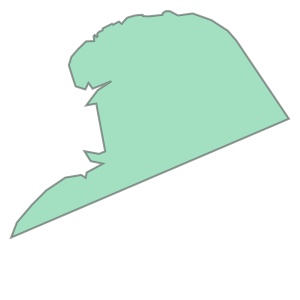

In [11]:
sea_poly

Now we have a polygon of the sea area based on Cartesian points. It is time to generate the areas again, excluding candidate areas from the sea.

In [12]:
# Cartesian coordinates of baku_center
baku_center_xy = geoloc_to_xy(baku_center)

# radius to search from baku_center
search_radius = 4000

# start values for both axes
x_min = baku_center_xy[0] - search_radius
y_min = baku_center_xy[1] - search_radius

# radius of a small region
small_square = 400
steps = int(search_radius * 2 / small_square)

latitudes = []
longitudes = []
xs = []
ys = []
distances = []

for i in range(0, steps):    
    for j in range(0, steps):
        x = x_min + i * small_square
        y = y_min + j * small_square
        if is_inside_circle(x, y, baku_center_xy[0], baku_center_xy[1], search_radius):
            if (sea_poly.contains(Point(x,y))):
                continue
            lon, lat = xy_to_geoloc(x, y)
            dist = distance(x, y, baku_center_xy[0], baku_center_xy[1])
            latitudes.append(lat)
            longitudes.append(lon)
            distances.append(dist)
            xs.append(x)
            ys.append(y)

print('Total', len(latitudes), 'regions generated.')

Total 217 regions generated.


In [13]:
map_baku = folium.Map(location=baku_center, zoom_start=13)
folium.Marker(baku_center, popup='Sahil st.').add_to(map_baku)
folium.Circle(baku_center, radius=1000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=2000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=3000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=4000, fill=False, color='white').add_to(map_baku)
folium.GeoJson(sea_area_geojson_file, style_function=polygon_style, name='geojson').add_to(map_baku)
for lat, lon in zip(latitudes, longitudes):    
    folium.Circle([lat, lon], radius=small_square, color='blue', fill=False).add_to(map_baku)       
map_baku

We now have candidate areas ready. Now let's obtain estimated addresses using the locations and put all together to make a dataset. **get_address()** is used to obtain an address for location [x,y].

In [14]:
try:
    area_dataframe = pd.read_csv("data/candidate_areas.csv")
except:
    addresses = []
    for lat, lon in zip(latitudes, longitudes):
        address = get_address([lat, lon])
        if address is None:
            address = 'NO ADDRESS'
        addresses.append(address)
        print(' .', end='')
    print(' done.')
    area_dataframe = pd.DataFrame({'Addr': addresses,
                          'Lat': latitudes, 'Lon': longitudes,
                          'X': xs, 'Y': ys, 'DistFromCenter': distances})
    area_dataframe.to_csv("data/candidate_areas.csv", index=False)

In [15]:
area_dataframe.head()

Unnamed: 0                                               Addr        Lat  \
0           0             47 Həsən bəy Zərdabi, Bakı, Azerbaijan  40.383597   
1           1  19 Abbas Mirzə Şərifzadə küçəsi, Bakı, Azerbaijan  40.370433   
2           2  12 Abbas Mirzə Şərifzadə küçəsi, Bakı, Azerbaijan  40.373391   
3           3            31/38, Mirali Seyidov, Baku, Azerbaijan  40.376348   
4           4                60 Matbuat avenue, Baku, Azerbaijan  40.379306   

         Lon             X             Y  DistFromCenter  
0  49.807604  3.474268e+06  5.097769e+06     4000.000000  
1  49.804498  3.474668e+06  5.096169e+06     3939.543121  
2  49.806241  3.474668e+06  5.096569e+06     3794.733192  
3  49.807984  3.474668e+06  5.096969e+06     3687.817783  
4  49.809728  3.474668e+06  5.097369e+06     3622.154055

In [16]:
len(area_dataframe)

217

Let's define the necessary functions for Foursquare. We use them to obtain necessary information based on generated candidate areas.

In [47]:
foursquare_client_id = '' # your Foursquare ID
foursquare_client_secret = '' # your Foursquare Secret
foursquare_version = '20180605' # Foursquare API version

food_root = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues

coffee_categories = [    
    '4bf58dd8d48988d16d941735', # Café
    '4bf58dd8d48988d1e0931735', # Coffee Shop    
    '4bf58dd8d48988d148941735', # Donut Shop
    '56aa371be4b08b9a8d5734c1' # Turkish Coffeehouse
    ]

def foursquare_get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def foursquare_format_address(location):
    address = ', '.join(location['formattedAddress'])    
    return address

def foursquare_is_restaurant(categories):
    restaurant_words = ['restaurant', 'diner', 'taverna', 'steakhouse']
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in restaurant_words:
            if r in category_name:
                return True        
    return False

def foursquare_is_coffeeshop(categories):    
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        if category_id in coffee_categories:
            return True
        
    return False

def foursquare_get_venues(lat, lon, radius=400, limit=100):
    version = '20180724'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        foursquare_client_id, foursquare_client_secret, foursquare_version,
        lat, lon, food_root, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   foursquare_get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   foursquare_format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues

def foursquare_get_restaurants(lats, lons):
    restaurants = {}
    coffee_shops = {}
    location_restaurants = []    
    for lat, lon in zip(lats, lons):                
        venues = foursquare_get_venues(lat, lon)
        area_restaurants = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_res = foursquare_is_restaurant(venue_categories)
            is_coffee_shop = foursquare_is_coffeeshop(venue_categories)            
            if is_res or is_coffee_shop:
                x, y = geoloc_to_xy([venue_latlon[0], venue_latlon[1]])
                restaurant = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_coffee_shop, x, y)
                if venue_distance<=300:
                    area_restaurants.append(restaurant)
                restaurants[venue_id] = restaurant
                if is_coffee_shop:
                    coffee_shops[venue_id] = restaurant
        location_restaurants.append(area_restaurants)
        print(' .', end='')
        
    print(' done.')
    return restaurants, coffee_shops, location_restaurants

Now we iterate over our candidate areas and get restaurants nearby them. Additionally, detect if they belong to coffee shops.

In [18]:
# Try to load from local file system in case we did this before
restaurants = {}
coffee_shops = {}
location_restaurants = []
loaded = False
try:
    with open('data/baku_restaurants.pkl', 'rb') as f:
        restaurants = pickle.load(f)
    with open('data/baku_coffee_shops.pkl', 'rb') as f:
        coffee_shops = pickle.load(f)
    with open('data/baku_restaurant_locations.pkl', 'rb') as f:
        location_restaurants = pickle.load(f)
    print('Restaurant data loaded.')
    loaded = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    restaurants, coffee_shops, location_restaurants = foursquare_get_restaurants(latitudes, longitudes)
    # Let's persists this in local file system
    with open('data/baku_restaurants.pkl', 'wb') as f:
        pickle.dump(restaurants, f)
    with open('data/baku_coffee_shops.pkl', 'wb') as f:
        pickle.dump(coffee_shops, f)
    with open('data/baku_restaurant_locations.pkl', 'wb') as f:
        pickle.dump(location_restaurants, f)        

Restaurant data loaded.


Let's have some statistics about our data.

In [19]:
print('Total number of restaurants:', len(restaurants))
print('Total number of coffee shops:', len(coffee_shops))

Total number of restaurants: 746
Total number of coffee shops: 200


In [20]:
pd.DataFrame(list(restaurants.values()), columns=["idx", "id", "name", "lat", "long", "addr", "is_coffee", "x", "y"])

idx                                   id       name  \
0    53909491498e2cb9381ee4ad                    Quzu Təndir&Kabab  40.369701   
1    4d975f1d744f3704e530d357                               Kaktus  40.373388   
2    51b03cac498e98a879e6afe2                           Point Cafe  40.370126   
3    53400ce3498e1b0e2549321b                   "Filiz" sadlig evi  40.369569   
4    510d16e4e4b0d7e113c3cf7a                          Олд Тбилиси  40.367770   
5    5bcad29ea35f460030106132                         Özsüt Elmlər  40.376009   
6    560949e9498eb093a0a9eb10                            Zamok Lva  40.378180   
7    4f8d90f8e4b07efba19c622c                           Dash Dövrü  40.377329   
8    517eabd2498e4a3bde703de6                             Cafepark  40.379545   
9    4f046656775b9e560e801c33                               Elbara  40.377668   
10   502e749ee4b08345cc58906d                    İstanbul Lahmacun  40.379397   
11   5090fb8ee4b0c3ef0a2b9b04                           Köhnə Qala  40.377211   
12   4fa4fe65e4b017a5df985377                      Aslan Pastanesi  40.376291   
13   56913020498edd32c92c88a2           * The 10* Pub & Restaurant  40.375700   
14   56596802498ee8885d9c076e                   The Fresh Tea Shop  40.375260   
15   527676d3498e0d29785b362c                              Zəfəran  40.381155   
16   512f6a65e4b07bfc058a9a2d                    Express Fast Food  40.380022   
17   5926d27ead910e280c8c9cca                             Göverçin  40.379797   
18   50cc616fe4b0e6c83b2b3750                     Dicle Restaurant  40.379531   
19   56f29cf0498e5fc27a049fa6                    Darçın Restaurant  40.384390   
20   53779f18498ee64df62a5f2b                           Brand Café  40.381832   
21   5636024c498e4d1ccd9c7dd6                                 Jale  40.383856   
22   56373705498e8209bc4dcd51            LUXOR Restaurant & Lounge  40.384103   
23   53c3f45e498e9d813eba6595                           Mozzarella  40.386036   
24   50e57872e4b0922524ceae93                     Mersinli Tantuni  40.385905   
25   5342c048498e8213786258f7                    Ayasofya Lahmacun  40.386050   
26   52eeaa1311d21039a6094acd                     purrengi cay evi  40.391458   
27   5082bfe3e4b0921f5c3e49f7                  Tural Şadlıq Sarayı  40.391241   
28   523b194f498ec1be93c1cf1f                                Avand  40.392981   
29   50519989e4b0506022a71eca                     Chirag Lobbi Bar  40.395156   
..                        ...                                  ...        ...   
716  5a468e95610f044748a30772                            Özgür Şef  40.377964   
717  5b61d1c82a7ab6002ce81e72                           VERTICAL29  40.378031   
718  5168185b498e4dd8fa0520ab                           Dolce Vita  40.377880   
719  50f1811ae4b0c79b192c32a0                     İstanbul Köftesi  40.377995   
720  51e815f7e4b00dc272757a25             La Maera Fish Restaurant  40.378050   
721  51794309e4b0046ed1b9cbfa                           Yellow Egg  40.377722   
722  5253d16f498ea09993ee09a7              Tavuk Dünyası "Meqafun"  40.377973   
723  5282177611d25213cccc657a                        Cafe Biscotti  40.377832   
724  5184c74e498efc16bb84245a                             Delestan  40.378048   
725  5a7c63ac8c812a047aefc106                       Lavaş Restoran  40.378021   
726  58b3e6f2076be15eeb30ee1d                  Nani Georgian House  40.378070   
727  5103fd06e4b0cc5c756d4e97                      Sheki Restorani  40.378614   
728  4f943d22e4b03cc49d7b5a28                          Qizil 10luq  40.379163   
729  57d6c3fb498e5dd3815dd3e9                                Blaze  40.380118   
730  4eca1769f79041351fbebca8                                 Au79  40.383170   
731  507c4a44e4b0109f37094498                           Safye Cafe  40.383139   
732  54564aa5498eade8af79fb3c                            Ag sheher  40.382344   
733  5718cab5498edca6723b4f1a                           S

In [21]:
pd.DataFrame(list(coffee_shops.values()), columns=["idx", "id", "name", "lat", "long", "addr", "is_coffee", "x", "y"])

idx                                id       name  \
0    51b03cac498e98a879e6afe2                        Point Cafe  40.370126   
1    517eabd2498e4a3bde703de6                          Cafepark  40.379545   
2    5090fb8ee4b0c3ef0a2b9b04                        Köhnə Qala  40.377211   
3    4fa4fe65e4b017a5df985377                   Aslan Pastanesi  40.376291   
4    56913020498edd32c92c88a2        * The 10* Pub & Restaurant  40.375700   
5    56596802498ee8885d9c076e                The Fresh Tea Shop  40.375260   
6    53779f18498ee64df62a5f2b                        Brand Café  40.381832   
7    5636024c498e4d1ccd9c7dd6                              Jale  40.383856   
8    52eeaa1311d21039a6094acd                  purrengi cay evi  40.391458   
9    571a7571498e21955e6a768b                       Şüşəli Kafe  40.371319   
10   4f96b99de4b0c9bdccc23719                          Sheraton  40.375247   
11   59344f7467a9fe18a1c6be53                Benzin yellow Cafe  40.375871   
12   504dc277e4b0c4f4a4c9fda5                      Limuzin Cafe  40.376825   
13   52e64fa7498e793db8abff99                              Karo  40.377506   
14   530765a7498ee79571609535                 tac mahal çay evi  40.380386   
15   516aef15e4b0e37673438f63           Orera Georgian Restoran  40.385619   
16   4eb7df9d2c5b53141b588989                     Cafe de Paris  40.390292   
17   551cfbec498e2762bd844df8                      Nargis Caffe  40.390730   
18   57811339498e8701c1b37101                       Fusion Cafe  40.390802   
19   4cd3eae411e65941d2e97252                     Ekspress Kafe  40.368912   
20   4fb28616e4b01bca555fff3b                      Express Cafe  40.368876   
21   52caed2b498ed0308bd356b0                Jumeirah Tea House  40.370491   
22   4ee087ac8b81e335ecabe44d                    Chocolate Cafe  40.372937   
23   4eb18703b8035a99ee3b765f                    Green Tea Club  40.373009   
24   525021a6498e85efc532f661                       Yashil Cafe  40.372946   
25   4cbea96fc44f9c749271bbdf                            Fincan  40.368896   
26   4ea2dce1003934222eb46d6d                             Yaşıl  40.373018   
27   5016c30fe4b0c7c30e43533b                         Cafe Park  40.377623   
28   54e302a6498eef120212dff5                Cosy Cafe & Lounge  40.381723   
29   540dba2a498e20a6ab61b741                     CafeCity Five  40.384137   
..                        ...                               ...        ...   
170  4e397471c65bab738fcfee14                      Kafe "Xəzər"  40.368114   
171  4fcb74c2e4b076524e1689a5                 Delfin Restaurant  40.368166   
172  5801f520d67c4f431d1e5409                             Hocca  40.377180   
173  50f9951fe4b097ebb0bea95d                          Club 111  40.377735   
174  50a8e049e4b0ea2d5a837509                  Shüa 'Çay Keyfi'  40.396165   
175  50e30131e4b0fe5be1c75c6c                  Platin tea house  40.397722   
176  4fd4e9fae4b0d45a95f33e6c                      Come in club  40.344395   
177  4ff49190e4b0f1c6176e3be7             Gilavar Cafe & Lounge  40.346236   
178  4fb77ab1e4b08e0bf9d9f842               ZEST Lifestyle Cafe  40.374745   
179  4ed11918f790d07039473f39                         Chocolate  40.380050   
180  5242f7ca11d24488ac5d400c                         Lilo kafe  40.345840   
181  59d7c3871f744075ee6addfd                           Alice’s  40.375179   
182  517374a5e4b0d8598e07eceb                            Qagayi  40.372339   
183  520ccda411d234d1eccafd5e                       Aura-Bulvar  40.372357   
184  597242937269fe3e6ba7ea6b              Cafe Fountain Lounge  40.371708   
185  5461d39a498eff19f85a0acb                         Baku Cafe  40.375976   
186  58388cd313af1c57616d5b6b                        Chaynataun  40.383490   
187  57aa3343498e5f5ea0943c8c                         Kn Lounge  40.394311   
188  535b9ee1498e1c1f30d3a400                      Harem lounge  40.394283   
189  51cf18b0498e6594b0e8d1a8                 Ma

In [22]:
print('Restaurants around location')
print('---------------------------')
for i in range(100, 110):
    rs = location_restaurants[i][:8]
    names = ', '.join([r[1] for r in rs])
    print('Restaurants around location {}: {}'.format(i+1, names))

Restaurants around location
---------------------------
Restaurants around location 101: Old School Cafe & Shop, IL Futuro Book Cafe, Qramofon Cafe, da Massimo, U Dali, Delice, El Viento art&crafts cafe, Palıd
Restaurants around location 102: Palıd, Innab Cafe&Lounge, Zanbaq, Meetpolitan
Restaurants around location 103: Meetpolitan
Restaurants around location 104: hezin lounge, "Görüş" restoranı, Mood Cafe Baku, Nori Sushi Bar, Sahil Kahve, Calibri Lounge, Yarpaq
Restaurants around location 105: Hollywood Cinema Club, hezin lounge, OBA restaurant, Long Forest Restaurant, Calibri Lounge
Restaurants around location 106: Hollywood Cinema Club, Soloha, istanbul Meyhane, Mangal Sefası, By Tike, Konya Sefasi, Drujba, Bay Tantuni
Restaurants around location 107: Soloha, istanbul Meyhane, Qoşa Qala, Mangal Sefası, By Tike, Konya Sefasi, Mixek, istanbul balik evi
Restaurants around location 108: Paul ADA
Restaurants around location 109: McDonald's
Restaurants around location 110: Özsüt Ganjlik 

Finally, data collection process is done. Let's see our final data on the map.

In [23]:
map_baku = folium.Map(location=baku_center, zoom_start=13)
folium.Marker(baku_center, popup='Baku').add_to(map_baku)
for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_coffee_shop = res[6]
    color = 'red' if is_coffee_shop else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_baku)
map_baku

## Methodology

Once we have data, it is time to conduct an analysis. Our method uses to search for regions within 4 kilometres from the city centre. The main criteria for that are followings:
* low density of restaurants
* less number of coffee shops around the area

The next step is to create heatmaps to see the conditions visually. Then we choose the regions that meet the criteria below.

The last step is finding clusters of the locations that meet our criteria for candidate areas. We use k-means clustering for this purpose.

Let's add number of surrounding restaurantsto our inital dataset. 

In [25]:
location_restaurants_count = [len(res) for res in location_restaurants]
area_dataframe['Restaurants in area'] = location_restaurants_count
area_dataframe.head(10)

Unnamed: 0                                               Addr        Lat  \
0           0             47 Həsən bəy Zərdabi, Bakı, Azerbaijan  40.383597   
1           1  19 Abbas Mirzə Şərifzadə küçəsi, Bakı, Azerbaijan  40.370433   
2           2  12 Abbas Mirzə Şərifzadə küçəsi, Bakı, Azerbaijan  40.373391   
3           3            31/38, Mirali Seyidov, Baku, Azerbaijan  40.376348   
4           4                60 Matbuat avenue, Baku, Azerbaijan  40.379306   
5           5          52 Zahid Xəlilov Küçəsi, Bakı, Azerbaijan  40.382263   
6           6          5B/2 Əhməd Cəmil Küçəsi, Bakı, Azerbaijan  40.385221   
7           7     273c Şəfayət Mehdiyev Küçəsi, Bakı, Azerbaijan  40.388178   
8           8             95 Shafayat Mehdiyev, Bakı, Azerbaijan  40.391135   
9           9              41 Mosvka prospekti, Bakı, Azerbaijan  40.394092   

         Lon             X             Y  DistFromCenter  Restaurants in area  
0  49.807604  3.474268e+06  5.097769e+06     4000.000000                    0  
1  49.804498  3.474668e+06  5.096169e+06     3939.543121                    3  
2  49.806241  3.474668e+06  5.096569e+06     3794.733192                    1  
3  49.807984  3.474668e+06  5.096969e+06     3687.817783                    4  
4  49.809728  3.474668e+06  5.097369e+06     3622.154055                    8  
5  49.811471  3.474668e+06  5.097769e+06     3600.000000                    5  
6  49.813215  3.474668e+06  5.098169e+06     3622.154055                    3  
7  49.814959  3.474668e+06  5.098569e+06     3687.817783                    2  
8  49.816704  3.474668e+06  5.098969e+06     3794.733192                    3  
9  49.818448  3.474668e+06  5.099369e+06     3939.543121                    6

Let's get the minimal distance to a nearest coffee shop from every candidate area.

In [26]:
distances_to_coffee_shops = []

for area_x, area_y in zip(xs, ys):
    min_distance = 10000
    for res in coffee_shops.values():
        res_x = res[7]
        res_y = res[8]
        d = distance(area_x, area_y, res_x, res_y)        
        if d<min_distance:
            min_distance = d
    distances_to_coffee_shops.append(min_distance)

area_dataframe['Distance to Coffee shop'] = distances_to_coffee_shops

In [27]:
area_dataframe.head()

Unnamed: 0                                               Addr        Lat  \
0           0             47 Həsən bəy Zərdabi, Bakı, Azerbaijan  40.383597   
1           1  19 Abbas Mirzə Şərifzadə küçəsi, Bakı, Azerbaijan  40.370433   
2           2  12 Abbas Mirzə Şərifzadə küçəsi, Bakı, Azerbaijan  40.373391   
3           3            31/38, Mirali Seyidov, Baku, Azerbaijan  40.376348   
4           4                60 Matbuat avenue, Baku, Azerbaijan  40.379306   

         Lon             X             Y  DistFromCenter  Restaurants in area  \
0  49.807604  3.474268e+06  5.097769e+06     4000.000000                    0   
1  49.804498  3.474668e+06  5.096169e+06     3939.543121                    3   
2  49.806241  3.474668e+06  5.096569e+06     3794.733192                    1   
3  49.807984  3.474668e+06  5.096969e+06     3687.817783                    4   
4  49.809728  3.474668e+06  5.097369e+06     3622.154055                    8   

   Distance to Coffee shop  
0               500.166878  
1                73.926962  
2               414.980535  
3               115.452467  
4               178.100199

It is time to create heatmaps based on our data. 

In [28]:
restaurant_locs = [[res[2], res[3]] for res in restaurants.values()]

In [29]:
map_baku = folium.Map(location=baku_center, zoom_start=13)
HeatMap(restaurant_locs).add_to(map_baku)
folium.Marker(baku_center).add_to(map_baku)
folium.Circle(baku_center, radius=1000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=2000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=3000, fill=False, color='white').add_to(map_baku)

for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_coffee_shop = res[6]
    color = 'red' if is_coffee_shop else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_baku)

map_baku

Let's see heatmap of coffee_shops.

In [30]:
coffee_shop_locs = [[res[2], res[3]] for res in coffee_shops.values()]

In [31]:
map_baku = folium.Map(location=baku_center, zoom_start=13)
HeatMap(coffee_shop_locs).add_to(map_baku)
folium.Marker(baku_center).add_to(map_baku)
folium.Circle(baku_center, radius=1000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=2000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=3000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=4000, fill=False, color='white').add_to(map_baku)

for res in coffee_shops.values():
    lat = res[2]; lon = res[3]        
    folium.CircleMarker([lat, lon], radius=3, color='red', fill=True, fill_color=color, fill_opacity=1).add_to(map_baku)
map_baku

The same way as we did in data collection section, let's generate candidate areas again. The only difference this time is we use smaller regions, to have them in large quantity. These points are used to analyse if they are good candidates for coffee shops. "Bad" ones are removed. Then we perform cluster analysis with remaining regions. 

In [32]:
baku_center_xy = geoloc_to_xy(baku_center)

search_radius = 4000

x_min = baku_center_xy[0]-search_radius
y_min = baku_center_xy[1]-search_radius

small_square = 100
steps = int(search_radius * 2 / small_square)

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
#distances = []

for i in range(0,steps):    
    for j in range(0,steps):
        x = x_min+i*small_square
        y = y_min+j*small_square        
        if is_inside_circle(x,y, baku_center_xy[0], baku_center_xy[1], search_radius):
            if (sea_poly.contains(Point(x,y))):
                continue
            lon, lat = xy_to_geoloc(x, y)            
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)            
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), ' neighborhoods.')

3439  neighborhoods.


In [34]:
color = 'green'
map_baku = folium.Map(location=baku_center, zoom_start=13)
folium.Marker(baku_center, popup='Sahil st.').add_to(map_baku)
for lat, lon in zip(roi_latitudes, roi_longitudes):
    folium.CircleMarker([lat, lon], radius=1, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_baku)    
folium.Circle(baku_center, radius=1000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=2000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=3000, fill=False, color='white').add_to(map_baku)
folium.Circle(baku_center, radius=4000, fill=False, color='white').add_to(map_baku)
map_baku

Now lets make a dataframe of the points we generated. Then add columns to indicate distance to closes coffee shop and number of restaurants.

In [35]:
# Let's put this into dataframe
df_roi_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys})

df_roi_locations.head(10)

Latitude  Longitude             X             Y
0  40.383597  49.807604  3.474268e+06  5.097769e+06
1  40.377348  49.805084  3.474368e+06  5.096969e+06
2  40.378088  49.805520  3.474368e+06  5.097069e+06
3  40.378827  49.805956  3.474368e+06  5.097169e+06
4  40.379567  49.806391  3.474368e+06  5.097269e+06
5  40.380306  49.806827  3.474368e+06  5.097369e+06
6  40.381045  49.807263  3.474368e+06  5.097469e+06
7  40.381785  49.807699  3.474368e+06  5.097569e+06
8  40.382524  49.808135  3.474368e+06  5.097669e+06
9  40.383263  49.808571  3.474368e+06  5.097769e+06

In [36]:
def count_restaurants_nearby(x, y, restaurants, radius=250):    
    count = 0
    for res in restaurants.values():
        res_x = res[7]; res_y = res[8]
        d = distance(x, y, res_x, res_y)
        if d<=radius:
            count += 1
    return count

def find_nearest_restaurant(x, y, restaurants):
    d_min = 100000
    for res in restaurants.values():
        res_x = res[7]; res_y = res[8]
        d = distance(x, y, res_x, res_y)
        if d<=d_min:
            d_min = d
    return d_min

roi_restaurant_counts = []
roi_coffee_distances = []

print('Generating data on location candidates... ', end='')
for x, y in zip(roi_xs, roi_ys):
    count = count_restaurants_nearby(x, y, restaurants, radius=250)
    roi_restaurant_counts.append(count)
    dist = find_nearest_restaurant(x, y, coffee_shops)
    roi_coffee_distances.append(dist)
print('done.')


Generating data on location candidates... done.


In [37]:
df_roi_locations['Restaurants nearby'] = roi_restaurant_counts
df_roi_locations['Distance to coffee shop'] = roi_coffee_distances

In [38]:
df_roi_locations.head()

Latitude  Longitude             X             Y  Restaurants nearby  \
0  40.383597  49.807604  3.474268e+06  5.097769e+06                   0   
1  40.377348  49.805084  3.474368e+06  5.096969e+06                   1   
2  40.378088  49.805520  3.474368e+06  5.097069e+06                   3   
3  40.378827  49.805956  3.474368e+06  5.097169e+06                   4   
4  40.379567  49.806391  3.474368e+06  5.097269e+06                   3   

   Distance to coffee shop  
0               500.166878  
1               229.107563  
2               216.347223  
3               200.633073  
4               138.974544

Let's exclude "bad" candidates from our dataframe.

In [39]:
good_res_count = np.array((df_roi_locations['Restaurants nearby']<=2))
good_coffee_distance = np.array(df_roi_locations['Distance to coffee shop']>=400)
good_locations = np.logical_and(good_res_count, good_coffee_distance)

df_good_locations = df_roi_locations[good_locations]

In [40]:
df_good_locations.head()

Latitude  Longitude             X             Y  Restaurants nearby  \
0   40.383597  49.807604  3.474268e+06  5.097769e+06                   0   
9   40.383263  49.808571  3.474368e+06  5.097769e+06                   0   
10  40.384003  49.809007  3.474368e+06  5.097869e+06                   1   
11  40.384742  49.809443  3.474368e+06  5.097969e+06                   2   
12  40.385482  49.809879  3.474368e+06  5.098069e+06                   2   

    Distance to coffee shop  
0                500.166878  
9                463.266007  
10               456.225271  
11               428.904142  
12               424.000034

In [41]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values
good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

map_baku = folium.Map(location=baku_center, zoom_start=14)
#HeatMap(restaurant_locs).add_to(map_baku)
folium.Marker(baku_center).add_to(map_baku)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='green', fill=True, fill_color='blue', fill_opacity=1).add_to(map_baku) 
for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_italian = res[6]
    color = 'red' if is_italian else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_baku)
map_baku

In the above map, we can see regions of good locations using green dots, restaurants and coffee shops with blue and red dots respectively.

It is time to run a cluster analysis using the K-means algorithm. We use the scikit-learn [12] module for this purpose. The number of clusters is chosen empirically.

In [45]:
from sklearn.cluster import KMeans

number_of_clusters = 30

good_xys = df_good_locations[['X', 'Y']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_geoloc(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

map_baku = folium.Map(location=baku_center, zoom_start=14)
HeatMap(restaurant_locs).add_to(map_baku)
folium.Circle(baku_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_baku)
folium.Marker(baku_center).add_to(map_baku)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=True, fill_opacity=0.25).add_to(map_baku) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='green', fill=True, fill_color='blue', fill_opacity=1).add_to(map_baku)
map_baku

Let's obtain addresses and make a dataset using our final data. 

In [43]:
candidate_area_addresses = []
candidate_distances_from_center = []

for lon, lat in cluster_centers:
    addr = get_address([lat, lon])
    candidate_area_addresses.append(addr)    
    x, y = geoloc_to_xy([lat, lon])
    d = distance(x, y, baku_center_xy[0], baku_center_xy[1])
    candidate_distances_from_center.append(d)
    
final_data = pd.DataFrame({"Address": candidate_area_addresses,
                          "Distance from center": candidate_distances_from_center})
final_data

Address  Distance from center
0                    Mikayıl Müşfiq, Bakı, Azerbaijan           3246.581876
1                       K.Səfərəliyeva 27, Azerbaijan           2061.212492
2                     Sabail square, Bakı, Azerbaijan           3615.058854
3            5D Akim Abbasov Küçəsi, Bakı, Azerbaijan           3716.901936
4   Bakı Ağ Şəhər Ofis Binası, 25 Nobel Prospekti,...           3744.705898
5        108 Azadlıq prospekti, Bakı 1005, Azerbaijan           3453.558730
6             Gülbala Əliyev küçəsi, Bakı, Azerbaijan           3656.744731
7              32 Fətəli Xan Xoyski, Bakı, Azerbaijan           3804.749985
8         120 Zulfu Adigozalov, Bakı 1009, Azerbaijan           2029.205167
9          10b Babək Prospekti, Bakı 1025, Azerbaijan           3100.678547
10                     Buxta küçəsi, Bakı, Azerbaijan           3544.381469
11                          Yasamal, Bakı, Azerbaijan           3627.672853
12               4 Hənifə Ələsgərov, Bakı, Azerbaijan           2941.323526
13      62 Neftçilər Prospekti, Bakı 1010, Azerbaijan           1364.734406
14  Baku City Main Police Department, Bakı, Azerba...           2725.445937
15           59 Mərdanov Qardaşları, Bakı, Azerbaijan           1633.986264
16       ул. Нахчивани 15, кв. 257а, Baku, Azerbaijan           3715.676251
17               Yuksak Inshaat MTK, Bakı, Azerbaijan           3853.014812
18                   Aydın Məmmədov, Bakı, Azerbaijan           2779.516665
19   Alley of Honor, Parlament Pros, Bakı, Azerbaijan           2593.147136
20          Süleyman Vəzirov küçəsi, Bakı, Azerbaijan           3861.141950
21                     Unnamed Road, Bakı, Azerbaijan           3737.002851
22            2 Həsən Əliyev Küçəsi, Bakı, Azerbaijan           3752.532138
23             Fәtәlixan Xoyski 75,, Baku, Azerbaijan           3586.975091
24                     Unnamed Road, Bakı, Azerbaijan           3182.309132
25                Atatürk prospekti, Bakı, Azerbaijan           3048.419821
26             White City Boulevard, Bakı, Azerbaijan           2295.844071
27   1 Heydər Əliyev prospekti, Bakı 1000, Azerbaijan           3234.510095
28                     Unnamed Road, Bakı, Azerbaijan           3207.181882
29  127 Nəriman Nərimanov Prospekti, Bakı 1009, Az...           2097.712320

In [44]:
final_data.to_csv("data/final_data.csv")

# Results

The result of our analysis shows that there are good neighbourhoods to open new coffee shops in Baku. At first it seemed that too many restaurants and coffee shops are there; however, after analysis, we found out that we still can open new ones not far from the city centre. Close distance to city centre guarantees good sales.

# Discussion

We found 30 regions using the criteria like the low density of restaurants and less number of coffee shops around. However, we can imporve our analysis by eliminating some areas such as national parks, the places that are reserved for future construction areas.

Additionally, some areas which are a little far from the city centre also can be good candidates for opening coffee shops because there are many companies, universities around that. Criteria like rental fee also could be useful.

As we are doing this report for educational purposes, I did not go that much deeper.

# Conclusion

My project aimed to find suitable areas for opening coffee shops. Suitable area means low restaurant density and less number of coffee shops around the area. 

This kind of analysis can be beneficial for stakeholders who want to open a coffee shop and looking for a suitable address.

We used Google Geocode API, Foursquare API to obtain interesting information. Besides that, we used data science techniques to generate final data. Clustering was performed to find significant centres and their addresses.

# Reference

1. https://cocl.us/coursera_capstone_notebook
2. Sercan Yıldız, Housing Sales Prices & Venues Data Analysis of Istanbul (https://www.linkedin.com/pulse/housing-sales-prices-venues-data-analysis-ofistanbul-sercan-y%C4%B1ld%C4%B1z/)
3. Google Geocoding API (https://developers.google.com/maps/documentation/geocoding/start)
4. Foursquare API (https://developer.foursquare.com/places-api)
5. Wikipedia Contributors. (2019, June 5). World Geodetic System. Retrieved from Wikipedia website: https://en.wikipedia.org/wiki/World_Geodetic_System
6. Nyu.edu. (2015). Boundary, Caspian Sea, 2015 - NYU Spatial Data Repository. [online] Available at: https://geo.nyu.edu/catalog/stanford-zb452vm0926.
7. Google Maps (2019). Google Maps. [online] Google Maps. Available at: https://maps.google.com [Accessed 23 Jun. 2019].
8. Wikipedia Contributors (2019). Keyhole Markup Language. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/Keyhole_Markup_Language [Accessed 23 Jun. 2019].
9. Wikipedia Contributors (2019). GeoJSON. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/GeoJSON [Accessed 23 Jun. 2019].
10. Mygeodata.cloud. (2018). KML to GeoJSON Converter Online - MyGeodata Cloud. [online] Available at: https://mygeodata.cloud/converter/kml-to-geojson [Accessed 23 Jun. 2019].
11. Readthedocs.io. (2018). The Shapely User Manual — Shapely 1.6 documentation. [online] Available at: https://shapely.readthedocs.io/en/stable/manual.html [Accessed 23 Jun. 2019].
12. Scikit-learn.org. (2010). 2.3. Clustering — scikit-learn 0.20.3 documentation. [online] Available at: https://scikit-learn.org/stable/modules/clustering.html#k-means.